In [179]:
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from dmba import regressionSummary
from pandas.api.types import is_datetime64_any_dtype
import numpy as np

In [180]:

bike_df = pd.read_csv(r"C:\Users\patri\Documents\Making_Data_Decisions_Files\dmba-datasets\day.csv")#convert date info to datetime object
bike_df.head(50)

bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [181]:
bike_df.dtypes
print(bike_df.dteday.dtype)  # datetime64[ns, UTC]

object


In [182]:
#Convert dataframe column to a series name is used to label the data
#I had a little trouble with the datetime stuff, finally got it locked in correctly
bike_df['dteday'] = pd.to_datetime(bike_df['dteday'])
rentals_ts = bike_df.set_index('dteday')['cnt']

In [183]:
rentals_ts = pd.Series(bike_df.cnt.values, index = bike_df.dteday, name= 'Rentals')
rentals_ts.head()

dteday
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
Name: Rentals, dtype: int64

In [184]:
#Define time series frequency
#I was fiddling with the date time and I kept trying to run this but it kept throwing the error AttributeError: 'Index' object has no attribute 'inferred_freq'
#but that was because I goofed up the not passing rentals_ts.index into the DatetimeIndex method, i just did rentals_ts on accident
rentals_ts.index = pd.DatetimeIndex(rentals_ts.index, freq=rentals_ts.index.inferred_freq)
rentals_ts.min()
rentals_ts.max()

np.int64(8714)

(0.0, 9000.0)

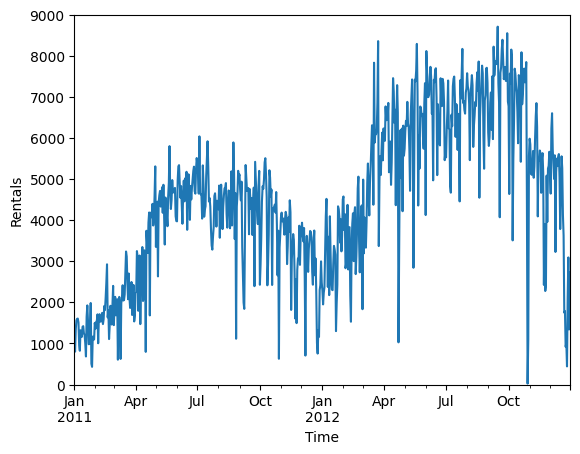

In [185]:
#plot it
ax = rentals_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Rentals')
ax.set_ylim(0,9000)
#There is a tremendous amount of variance.

In [186]:
rental_ts_1yrs = rentals_ts['2011':'2012']

In [187]:
rentals_ts= tsatools.add_trend(rentals_ts, trend='ctt')

In [188]:
rentals_lm = sm.ols(formula = 'Rentals ~ trend + trend_squared', data=rentals_ts).fit()

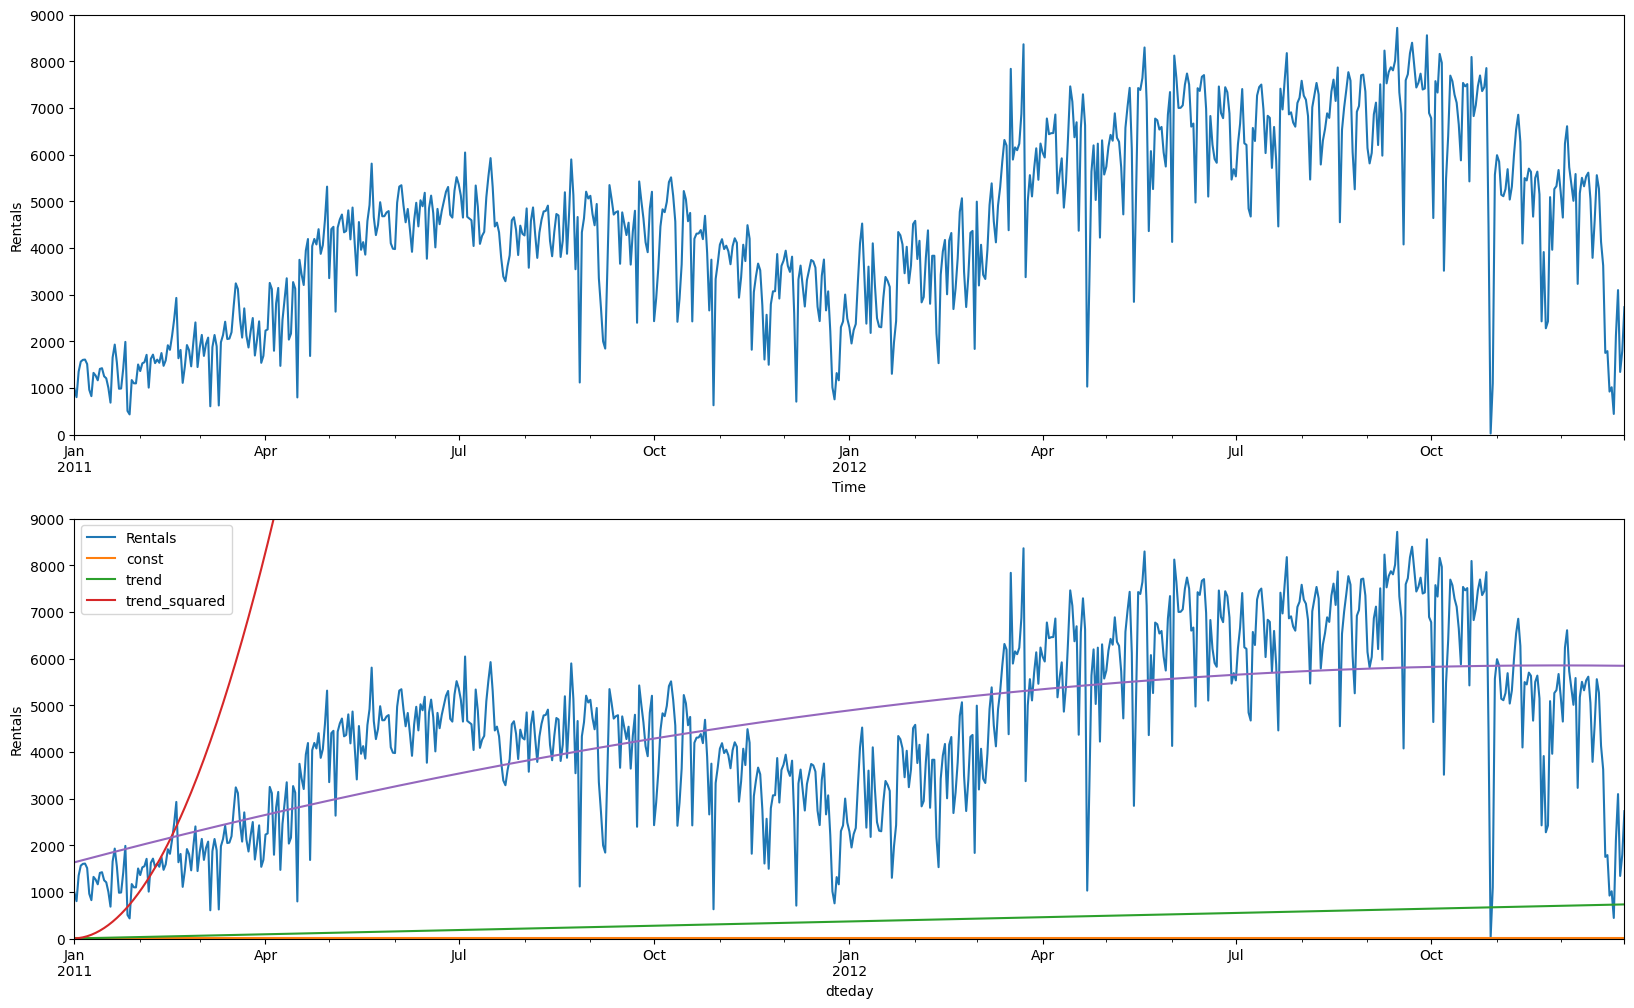

In [189]:
fig,axes = plt.subplots(nrows=2, ncols=1, figsize=(20,12))
rental_ts_1yrs.plot(ax=axes[0])
rentals_ts.plot(ax=axes[1])
for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('Rentals')
    ax.set_ylim(0,9000)
rentals_lm.predict(rentals_ts).plot(ax=axes[1])
plt.show()

In [190]:
#Start with Naive approach to use as a benchmark
#nValid is the number of months
nValid = 12
nTrain = len(rentals_ts) - nValid

In [191]:
#partition data into 2011 and 2012 sets
train_ts = bike_df.loc[bike_df['dteday'].dt.year == 2011].set_index('dteday')['cnt']
valid_ts = bike_df.loc[bike_df['dteday'].dt.year == 2012].set_index('dteday')['cnt']
last_2011 = train_ts.iloc[-1]
naive_pred = pd.Series(last_2011, index=valid_ts.index, name='naive_pred')

In [192]:
#accuracy check 
mae = (valid_ts - naive_pred).abs().mean()
rmse = np.sqrt(((valid_ts - naive_pred)**2).mean())
print(f"Naive (2012) MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Naive (2012) MAE: 3223.65, RMSE: 3590.74


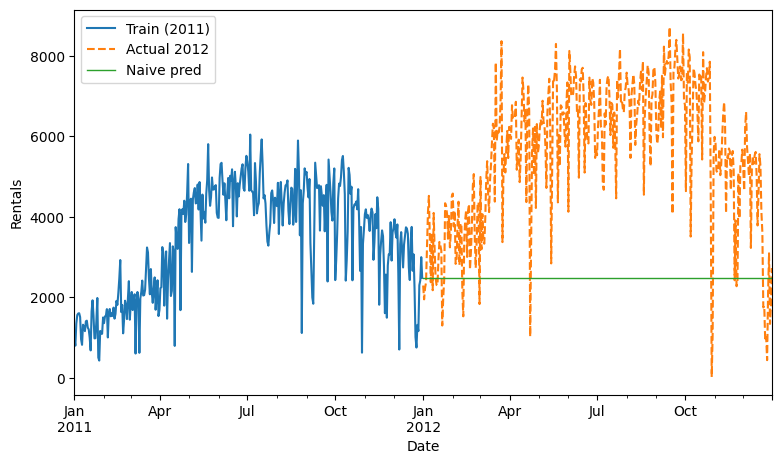

In [193]:
# Plot
ax = train_ts.plot(figsize=(9,5), label='Train (2011)')
valid_ts.plot(ax=ax, label='Actual 2012', linestyle='--')
naive_pred.plot(ax=ax, label='Naive pred', linewidth=1)
ax.legend(); ax.set_ylabel('Rentals'); ax.set_xlabel('Date');

In [194]:
#The naive prediction seems extremely low
#lets look at some summary
regressionSummary(valid_ts, naive_pred)
#The RSME is quit high, perhaps I could try to divide the dataset up to predict the last quarter


Regression statistics

                      Mean Error (ME) : 3114.9344
       Root Mean Squared Error (RMSE) : 3590.7392
            Mean Absolute Error (MAE) : 3223.6503
          Mean Percentage Error (MPE) : 15.5287
Mean Absolute Percentage Error (MAPE) : 85.4587


In [195]:
# Add quarter index (relative to the earliest date)
bike_df['quarter_id'] = ((bike_df['dteday'].dt.year - bike_df['dteday'].dt.year.min()) * 4 
                         + (bike_df['dteday'].dt.quarter))
#partition into quarters
train_ts = bike_df.loc[bike_df['quarter_id'] <= 7].set_index('dteday')['cnt']
valid_ts = bike_df.loc[bike_df['quarter_id'] == 8].set_index('dteday')['cnt']

In [196]:
#naive forcast for our final quarter
naive_pred = pd.Series(train_ts.iloc[-1], index=valid_ts.index, name='naive_pred')

In [197]:
# Accuracy check
mae = (valid_ts - naive_pred).abs().mean()
rmse = np.sqrt(((valid_ts - naive_pred)**2).mean())
print(f"Naive forecast MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Naive forecast MAE: 1987.43, RMSE: 2579.79


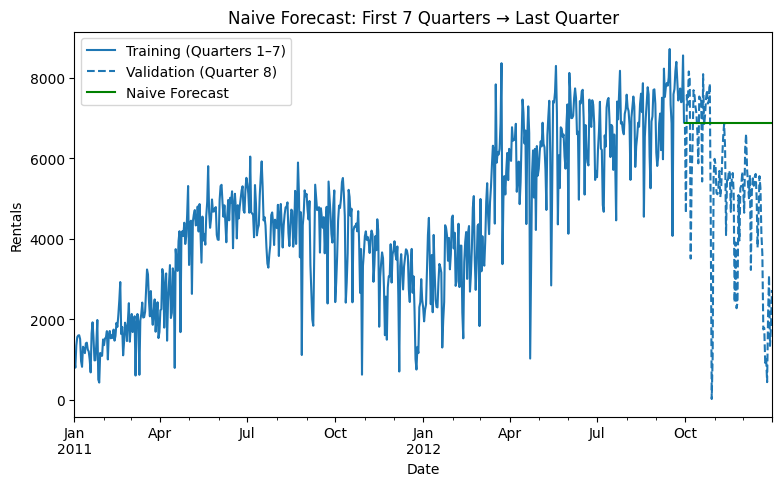

In [198]:
#this produced a better MAE, but still pretty high
#lets plot it
ax = train_ts.plot(figsize=(9,5), label='Training (Quarters 1–7)', color='C0')
valid_ts.plot(ax=ax, label='Validation (Quarter 8)', linestyle='--', color='C0')
naive_pred.plot(ax=ax, label='Naive Forecast', color='green')
ax.legend(); ax.set_ylabel('Rentals'); ax.set_xlabel('Date');
# Labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Rentals')
ax.set_title('Naive Forecast: First 7 Quarters → Last Quarter')
ax.legend()

plt.show()

In [239]:
#Lets use a linear model and see if we can do any better
#fit a linear trend model to the time series
rentals_ts = pd.Series(bike_df.cnt.values, index = bike_df.dteday, name= 'Rentals')
#create a dataframe with additional predictors from time series
#the following commands adds a constant term, a trend term and a quadratic trend term
rentals_df= tsatools.add_trend(rentals_ts, trend='ctt')
#fit a linear regression model to the time series
rentals_ts = bike_df.set_index('dteday')['cnt']
rentals_lm = sm.ols(formula = 'Rentals ~ trend', data=rentals_df).fit()

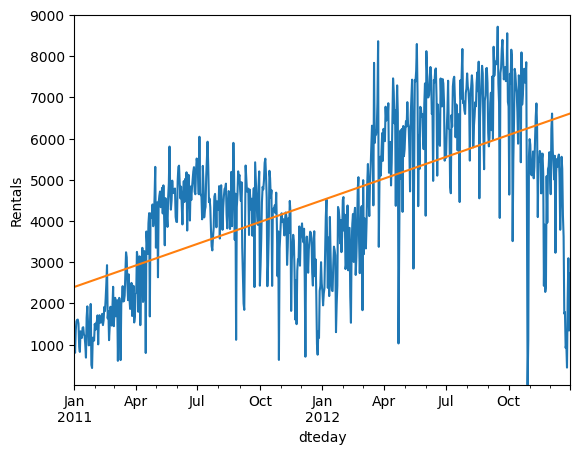

In [240]:
#plotting our linear formula to the rentals
ax = rentals_ts.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Rentals')
ax.set_ylim(30,9000)
rentals_lm.predict(rentals_df).plot(ax=ax)
plt.show()


In [282]:
import numpy as np

# Start from bike_df with 'dteday' datetime and 'Rentals' column
full = bike_df.set_index('dteday')[['Rentals']].copy()

# Create a linear time trend (1,2,3,...)
full['trend'] = np.arange(1, len(full) + 1)

# Your quarter split indices (first 7 quarters vs last quarter)
# assuming you've already made `quarter_id` in bike_df:
q = bike_df.set_index('dteday')['quarter_id'].reindex(full.index)

train_mask = q <= 7
valid_mask = q == 8

train_df = full.loc[train_mask].copy()
valid_df = full.loc[valid_mask].copy()
train_df['yhat'] = rentals_lm.predict(train_df)
valid_df['yhat'] = rentals_lm.predict(valid_df)
train_df['resid'] = train_df['Rentals'] - train_df['yhat']
valid_df['resid'] = valid_df['Rentals'] - valid_df['yhat']

In [283]:
#fit linear model using training set and predict on validation set
bike_df['dteday'] = pd.to_datetime(bike_df['dteday'])
bike_df = bike_df.rename(columns={'cnt':'Rentals'})
bike_df['quarter_id'] = ((bike_df['dteday'].dt.year - bike_df['dteday'].dt.year.min()) * 4
                         + bike_df['dteday'].dt.quarter)
rentals_lm = smf.ols(formula='Rentals ~ trend', data=train_df).fit()
train_df['yhat'] = rentals_lm.predict(train_df)
valid_df['yhat'] = rentals_lm.predict(valid_df)


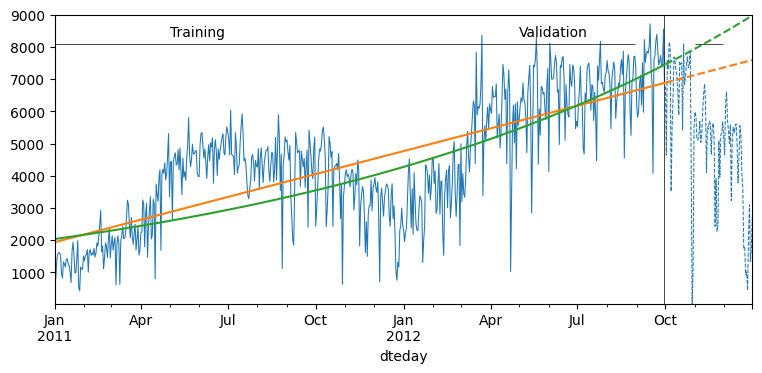

In [285]:
import numpy as np
import math
import statsmodels.formula.api as smf
#This is a bit of a black box to me, I was using our lesson to build it and it got away from me a little bit
rentals_lm_linear = smf.ols(formula='Rentals ~ trend', data=train_df).fit()
predict_df_linear = rentals_lm_linear.predict(valid_df)
rentals_lm_expo = sm.ols(formula='np.log(Rentals) ~ trend',
data=train_df).fit()
predict_df_expo = rentals_lm_expo.predict(valid_df)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,3.75))
train_df.plot(y='Rentals', ax=ax, color='C0', linewidth=0.75)
valid_df.plot(y='Rentals', ax=ax, color='C0',
linestyle='dashed', linewidth=0.75)
singleGraphLayout(ax, [30, 9000], train_df, valid_df)
rentals_lm_linear.predict(train_df).plot(color='C1')
rentals_lm_linear.predict(valid_df).plot(color='C1',
linestyle='dashed')
rentals_lm_expo.predict(train_df).apply(lambda row:
math.exp(row)).plot(color='C2')
rentals_lm_expo.predict(valid_df).apply(lambda row:
math.exp(row)).plot(color='C2', linestyle='dashed')
ax.get_legend().remove()
plt.show()